<a href="https://colab.research.google.com/github/DarioRugg/KickLearning/blob/main/regression_notebooks/Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os.path import join
from os import listdir
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt

data_path = join('drive', 'MyDrive', 'Project', 'Data')
full_df = pd.read_csv(join(data_path, 'final_dataset.csv'))

In [3]:
translated_path = join(data_path, 'texts_translated')
translated = pd.concat([pd.read_csv(join(translated_path, name)) for name in sorted(listdir(translated_path))], ignore_index=True)

In [4]:
def correct_tiers(entry):
  ls = eval(entry['tiers_values']) if type(entry.tiers_values) == str else [0]
  if sorted(ls)!=ls:
    for i in range(len(ls), -1, -1):
      if sorted(ls[:i+1])==ls[:i+1] and ls[i]>=500:
        entry['tiers_values'] = [tier if j<=i or tier>10 else int(tier*1e3) for j, tier in enumerate(ls)]
        break
      else:
        entry['tiers_values'] = ls
  return entry
translated.loc[:, 'tiers_values'] = translated[['tiers_values']].apply(correct_tiers, axis=1)

In [5]:
def get_statistics_tiers(var):
  var_array = eval(var) if type(var) == str else var
  n = len(var_array) if type(var_array) is list else 0
  if n:
    length = n
    avg = sum(var_array)/n
    maxim = max(var_array)
    minim = min(var_array)
    std = np.std(var_array)
    median = np.median(var_array)
    return [length, avg, maxim, minim, std, median]
  else:
    return [0,0,0,0,0,0]

In [6]:
tiers_df = pd.DataFrame(list(map(get_statistics_tiers, translated['tiers_values'].to_list())),
                        columns=['n_tiers', 'tiers_values_mean', 'tiers_values_max',
                                 'tiers_values_min', 'tiers_values_std', 'tiers_values_median'])
reduced = translated[['id', 'story', 'lang']].copy()
reduced = pd.concat([reduced, tiers_df], axis=1)
reduced.loc[:,'story'] = reduced['story'].apply(lambda x :len(x) if type(x)==str else 0)

In [7]:
full_df = pd.merge(full_df.drop(columns=['tiers_values_mean', 'tiers_values_max',
                                 'tiers_values_min', 'tiers_values_std', 'tiers_values_median', 'n_tiers']), reduced, on='id')

Preprocessing variables

In [8]:
def fun(j):
    return list(set(re.findall(r'\'(\b\w+\b)\'', j) + list(map(lambda x: x[0]+" " +x[1], re.findall(r"\"(\w+).*?(\w \w+)\"", j)))))
data = full_df.copy()
data = data[data['state'].isin(['successful', 'failed'])]
data.loc[:, 'category'] = data['category'].apply(fun)
data.loc[:, 'sub_category'] = data['sub_category'].apply(fun)

data.loc[:, 'duration'] = (data['deadline']-data['launched_at'])/86400
data.loc[:, 'usd_goal'] = data['goal']*data['fx_rate']
data.loc[:, 'state'] = data['state'].apply(lambda x: 1 if x=='successful' else 0)
data = data[data['usd_pledged'] >= 1]
data = data[data['usd_pledged'] <= 2e6]
data = data[data['lang'] != 'unknown']
data = data[data['story'] >= 150]
data = data.drop(columns=['id', 'project_url', 'image', 'fx_rate', 'launched_at', 'deadline', 'goal'])
data = data.dropna(axis = 0, how ='any')

weekday = {'Mon':1, 'Tue':2, 'Wed':3, 'Thu':4, 'Fri':5, 'Sat':6, 'Sun':7}
month = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 
         'June':6, 'July':7, 'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
data.loc[:, 'Launch_Week'] = data['Launch_Week'].apply(lambda x: weekday[x])
data.loc[:, 'Deadline_Week'] = data['Deadline_Week'].apply(lambda x: weekday[x])
data.loc[:, 'Launch_Month'] = data['Launch_Month'].apply(lambda x: month[x])
data.loc[:, 'Deadline_Month'] = data['Deadline_Month'].apply(lambda x: month[x])

# Dealing with categorical variables

Target encoding and weight of evidence for regression and classification targets is used, after splitting train and test

In [9]:
drop_cols = ['Deadline_Week', 'Deadline_Day', 'Deadline_Year']

In [10]:
reg_data = data.drop(columns=drop_cols)

In [11]:
reg_data.loc[:, [col for col in reg_data.columns if 'text' in col]] = ((reg_data.story.to_numpy()/reg_data.story.max())*reg_data.loc[:, [col for col in reg_data.columns if 'text' in col]].to_numpy().T).T

In [12]:
X, y_class, y_reg = [reg_data.drop(columns=['usd_pledged', 'state']), reg_data.state, reg_data.usd_pledged]

The problem with our categorical variables is that they are lists of categories, not just plain categories, so we have to find the indices of projects that contain each single category, average pledge amounts and compute success rate for each category, and then embed each list of categories as the average of the scores relative to each single category.

In [13]:
def weighted_avg(vector):
  '''
  vector is a binary [0,1] vector, so the mean corresponds to the success
  frequency, and 1-mean is the failure frequency
  '''
  n = len(vector)
  if n>0:
    avg = np.mean(vector)
    # log_odd = np.log(np.mean(vector)/(1-np.mean(vector))) if np.mean(vector)<0.9 else np.log(10)
    return (n, avg)
  else:
    return (0,0)

class CategoricalEmbeddings():
  def __init__(self, feature_names: list):
    self.categorical_features = feature_names
    
  
  def fit(self, X, y_class=None, y_reg=None):
    self.embeddings = dict()
    arr = X[self.categorical_features].copy()
    self.reg = y_reg is not None
    self.clas = y_class is not None
    
    for categorical in self.categorical_features:
      
      if type(X[categorical].iloc[0]) == list:  
        cats = set([cat for l in X[categorical] for cat in l])
        indices = {cat:[] for cat in cats}
        for i, row in arr[categorical].iteritems():
          for cat in row:
            indices[cat].append(i)
        # each category is represented by a tuple with the odds of success and the average
        # pledged amount of projects belonging to the category (in this order)
        if self.reg and self.clas:
          self.embeddings[categorical] = {cat:(weighted_avg(y_class.loc[indices[cat]]),(y_reg.loc[indices[cat]].mean())) for cat in cats}
        elif self.clas:
          self.embeddings[categorical] = {cat:weighted_avg(y_class.loc[indices[cat]]) for cat in cats}
        elif self.reg:
          self.embeddings[categorical] = {cat:y_reg.loc[indices[cat]].mean() for cat in cats}
        else:
          print('Target Variable missing')
      
      elif type(X[categorical].iloc[0]) == str:
        cats = set([cat for cat in X[categorical]])
        indices = {cat:[] for cat in cats}
        for i, cat in arr[categorical].iteritems():
          indices[cat].append(i)      
        if self.reg and self.clas:
          self.embeddings[categorical] = {cat:(weighted_avg(y_class.loc[indices[cat]]),y_reg.loc[indices[cat]].mean()) for cat in cats}
        elif self.clas:
          self.embeddings[categorical] = {cat:weighted_avg(y_class.loc[indices[cat]]) for cat in cats}
        elif self.reg:
          self.embeddings[categorical] = {cat:(len(y_reg.loc[indices[cat]]), y_reg.loc[indices[cat]].mean()) for cat in cats}
        else:
          print('Target Variable missing')



  def fit_transform(self, X, y_class=None, y_reg=None):
    self.fit(X=X, y_class=y_class, y_reg=y_reg)
    return self.transform(X)


  def transform(self, X):
    if self.reg and self.clas:
      return self._transform_both(X)
    elif self.clas:
      return self._transform_class(X)
    elif self.reg:
      return self._transform_reg(X)
    else:
      print('Target Variable missing')
      return None

  def _transform_both(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
      embeddings = self.embeddings[categorical]
      cat_pledged = []
      combined_odds = []
      for i, row in X_copy[categorical].iteritems():
        if type(row) == list:
          pledged = 0
          odds = 0
          lens = []
          for cat in row:
            try:
              n = embeddings[cat][0][0]
              log_odd = embeddings[cat][0][1]
              lens.append(n)
              odds += n*log_odd
              pledged += n*embeddings[cat][1]   
            except:
              print(f'Found new key {cat} not seen in fit')
          avg_pledged = pledged/sum(lens) if len(lens) else 0
          combine_odds = odds/sum(lens) if len(lens) else 0
          cat_pledged.append(avg_pledged)
          combined_odds.append(combine_odds)
        elif type(row) == str:
          try:
            combined_odds.append(embeddings[row][0][1])
            cat_pledged.append(embeddings[row][1])
            
          except:
            print(f'Found new key {row} not seen in fit')
            cat_pledged.append(0)
            combined_odds.append(0)
      X_copy.loc[:, f'{categorical}_pledged'] = cat_pledged
      X_copy.loc[:, f'{categorical}_odds'] = combined_odds 
      X_copy = X_copy.drop(columns=[categorical])
    return X_copy

  def _transform_class(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
      embeddings = self.embeddings[categorical]
      combined_odds = []
      for i, row in X_copy[categorical].iteritems():
        if type(row) == list:
          odds = 0
          lens = []
          for cat in row:
            try:
                n = embeddings[cat][0]
                log_odd = embeddings[cat][1]
                lens.append(n)
                odds += n*log_odd
            except:
              print(f'Found new key {cat} not seen in fit')
          combine_odds = odds/sum(lens) if len(lens) else 0
          combined_odds.append(combine_odds)
        elif type(row) == str:
          try:
            combined_odds.append(embeddings[row][1])
            
          except:
            print(f'Found new key {row} not seen in fit')
            combined_odds.append(0)
      X_copy.loc[:, f'{categorical}_odds'] = combined_odds 
      X_copy = X_copy.drop(columns=[categorical])
    return X_copy
  
  def _transform_reg(self, X):
    X_copy = X.copy()
    for categorical in self.categorical_features:
        embeddings = self.embeddings[categorical]
        cat_pledged = []
        for i, row in X_copy[categorical].iteritems():
            if type(row) == list:
              pledged = 0
              lens = []
              for cat in row:
                try:
                  n = embeddings[cat][0]
                  lens.append(n)
                  pledged += n*embeddings[cat][1]   
                except:
                  print(f'Found new key {cat} not seen in fit')
              avg_pledged = pledged/sum(lens) if len(lens) else 0
              cat_pledged.append(avg_pledged)
            elif type(row) == str:
              try:
                cat_pledged.append(embeddings[row][1])

              except:
                print(f'Found new key {row} not seen in fit')
                cat_pledged.append(0)
        X_copy.loc[:, f'{categorical}_pledged'] = cat_pledged
        X_copy = X_copy.drop(columns=[categorical])
    return X_copy

In [14]:
categorical_feat = ['category', 'country', 'sub_category', 'lang']

In [15]:
train_X, test_X, train_y_reg, test_y_reg =  train_test_split(X, y_reg,test_size=0.2,
                                                              random_state=1234)
train_y_class = y_class[train_y_reg.index]
test_y_class = y_class[test_y_reg.index]

In [16]:
train_X, val_X, train_y_reg, val_y_reg = train_test_split(train_X, train_y_reg, test_size=0.2, random_state=1234)
train_y_class = y_class[train_y_reg.index]
val_y_class = y_class[val_y_reg.index]

In [17]:
embed = CategoricalEmbeddings(categorical_feat)

In [18]:
train_X = embed.fit_transform(train_X, train_y_class)
val_X = embed.transform(val_X)
test_X = embed.transform(test_X)

Found new key el not seen in fit
Found new key hu not seen in fit
Found new key ts not seen in fit
Found new key eu not seen in fit
Found new key el not seen in fit


In [19]:
cols = [col for col in train_X.columns if any(x in col for x in ['historic_','collabs_','category','country','sub_category_'])]
train_X.loc[:, cols] = train_X[cols].mask(train_X[cols]==0).fillna(train_X[cols][train_X[cols]!=0].mean())
val_X.loc[:, cols] = val_X[cols].mask(val_X[cols]==0).fillna(val_X[cols][val_X[cols]!=0].mean())
test_X.loc[:, cols] = test_X[cols].mask(test_X[cols]==0).fillna(test_X[cols][test_X[cols]!=0].mean())

# Regression Model

# Neural

In [20]:
from __future__ import print_function
from os.path import join

import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from time import time


import sklearn

import re

import pandas as pd
from sklearn.svm import SVR
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from os.path import join
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import sklearn
import re
import matplotlib.pyplot as plt

In [21]:
scaler = StandardScaler()
device = 'cuda'
train_dataset = TensorDataset(torch.Tensor(scaler.fit_transform(train_X).astype("float32")).to(device), torch.Tensor((train_y_reg.to_numpy()).astype("float32")).to(device))
val_dataset = TensorDataset(torch.Tensor(scaler.transform(val_X).astype("float32")).to(device), torch.Tensor((val_y_reg.to_numpy()).astype("float32")).to(device))
test_dataset = TensorDataset(torch.Tensor(scaler.transform(test_X).astype("float32")).to(device), torch.Tensor((test_y_reg.to_numpy()).astype("float32")).to(device))

train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=64)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64)

In [22]:
class DeepRegressor(nn.Module):
        def __init__(self, input_size, hidden_size, dropout= 0.07, activation="relu", batchnorm=False, n_hidden_layers=5):
            super(DeepRegressor, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.num_hidden_layers = n_hidden_layers
            self.do_batchnorm = batchnorm
            self.batch_norm = nn.BatchNorm1d(self.input_size)
            if activation =="elu":
                activation = nn.ELU
            elif activation=="relu":
                activation = nn.ReLU
            elif activation=="sigmoid":
                activation = nn.Sigmoid
            elif activation=="tanh":
                activation = nn.Tanh
            elif activation=="silu":
                activation = nn.SiLU
            self.first_layer = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                             nn.Dropout(dropout),
                                             activation())


            self.hidden_layers = nn.Sequential()
            for _ in range(self.num_hidden_layers):
                self.hidden_layers.add_module("linear", nn.Linear(self.hidden_size, self.hidden_size))
                # self.hidden_layers.add_module("dropout", nn.Dropout(0.02))
                self.hidden_layers.add_module("activation", activation())
                
            self.last_layer1 = nn.Sequential(nn.Linear(self.hidden_size*2, int(self.hidden_size)),
                                             activation())
            self.last_layer2 = nn.Linear(int(self.hidden_size), 1)

        def forward(self, x):
            if self.do_batchnorm:
                x = self.batch_norm(x)
            hidden_state = self.first_layer(x)
            x = self.hidden_layers(hidden_state)
            x = torch.cat((x, hidden_state), dim=1)
            x = self.last_layer1(x)
            output = self.last_layer2(x)
            return output.squeeze(1)

In [23]:
# sweep_id = wandb.sweep(sweep_config, project="regression-final")
def train(config=None):
    with wandb.init(config=config, project="regression-final"):
        config = wandb.config
        model = DeepRegressor(train_X.to_numpy().shape[1], config.neurons, dropout=config.dropout, 
                              activation=config.activation, batchnorm=config.batchnorm,                              
                              n_hidden_layers=config.hidden_layers).to(device)
        criterion = nn.SmoothL1Loss(reduction='mean', beta=config.beta)
        mse = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(model.parameters(), lr = config.learning_rate, weight_decay=config.weight_decay)

        for param in model.parameters():
            param.requires_grad = True

        epoch = config.epochs
        rmse = {"train": np.zeros(epoch), "val": np.zeros(epoch)}
        losses = {"train": np.zeros(epoch), "val": np.zeros(epoch)}
        best = {"loss": None, "state_dict": None}

        start_training = time()
        for epoch in range(epoch):
            start_epoch = time()
            model.train()
            for i, batch in enumerate(train_dataloader, 0):
                # if i == 2: break

                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = batch

                optimizer.zero_grad()
                # Forward pass
                y_pred = model(inputs)
                # Compute Loss
                loss = criterion(y_pred, labels)

                # Backward pass
                loss.backward()
                optimizer.step()
                # print(y_pred.size())
                rmse["train"][epoch] += (mse(y_pred, labels)/len(train_dataloader)).item()
                losses["train"][epoch] += loss/len(train_dataloader)

            if epoch%1 == 0:
              print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {np.sqrt(rmse['train'][epoch])}")
              print(f"    Train   loss: {losses['train'][epoch]}")

            model.eval()
            for i, batch in enumerate(val_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = batch
                with torch.no_grad():
                    outputs = model(inputs)
                loss = criterion(outputs, labels)
                # forward + backward + optimize
                rmse["val"][epoch] += (mse(outputs, labels)/len(val_dataloader)).item()
                losses["val"][epoch] += loss/len(val_dataloader)
            wandb.log({"rmse": np.sqrt(rmse['train'][epoch]), "SmoothL1": losses['train'][epoch],
                       "val_rmse": np.sqrt(rmse['val'][epoch]), "val_SmoothL1": losses['val'][epoch]})
            if epoch%1 == 0:
              print(f"    Val   RMSE loss: {np.sqrt(rmse['val'][epoch])}")
              print(f"    Val  loss: {losses['val'][epoch]}")

            # check for overfitting:
            early_stopping_steps = 5
            if len(rmse["val"]) > 4 and \
                    all(map(lambda x: x[0]<x[1], zip(rmse["val"][-(early_stopping_steps)-1:-1], rmse["val"][-(early_stopping_steps):]))) and \
                    all(map(lambda x: x[0]>x[1], zip(rmse["train"][-(early_stopping_steps)-1:-1], rmse["train"][-(early_stopping_steps):]))):
                break

            if best["loss"] is None or best["loss"] > rmse["val"][epoch]:
                best["loss"] = rmse["val"][epoch]
                best["state_dict"] = model.state_dict()

            #scheduler.step()
            if epoch%1 == 0:
              print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")

        print('\n\n****************** Finished Training ******************')
        print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")

# wandb.agent(sweep_id, train)

In [24]:
%%capture
!pip install wandb

In [25]:
import wandb
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
%%wandb
torch.manual_seed(1234)
model = DeepRegressor(train_X.to_numpy().shape[1], 200, n_hidden_layers=19, activation="relu", batchnorm=False).to(device)
wandb.watch(model)
criterion = nn.SmoothL1Loss(reduction='mean', beta=5)
mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 5e-4, weight_decay=0.005)

for param in model.parameters():
    param.requires_grad = True
epoch = 120
rmse = {"train": [], "val": []}
l1 = {"train": [], "val": []}
best = {"loss": None, "state_dict": None}

start_training = time()
for epoch in range(epoch):
    if epoch%5 == 0:
        start_epoch = time()
    model.train()
    
    rmse["train"].append(0)
    l1["train"].append(0)
    for i, batch in enumerate(train_dataloader, 0):
        
        # if i == 2: break

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(inputs)
        
        # Compute Loss
        
        loss = criterion(y_pred, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # print(y_pred.size())
        rmse["train"][epoch] += (mse(y_pred, labels)/len(train_dataloader)).item()
        l1["train"][epoch] += loss/len(train_dataloader)
    if epoch%5 == 0:
      print(f"\n------> Epoch {epoch+1} <------\n    Train RMSE loss: {np.sqrt(rmse['train'][epoch])}")
      print(f"    Train   L1 loss: {l1['train'][epoch]}")
    
    model.eval()
    rmse["val"].append(0)
    l1["val"].append(0)
    for i, batch in enumerate(val_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        # forward + backward + optimize
        rmse["val"][epoch] += (mse(outputs, labels)/len(val_dataloader)).item()
        l1["val"][epoch] += loss/len(val_dataloader)
    wandb.log({"rmse": np.sqrt(rmse['train'][epoch]), "SmoothL1": l1['train'][epoch],
                       "val_rmse": np.sqrt(rmse['val'][epoch]), "val_SmoothL1": l1['val'][epoch]})
    if epoch%5 == 0:
      print(f"    Val   RMSE loss: {np.sqrt(rmse['val'][epoch])}")
      print(f"    Val   L1 loss: {l1['val'][epoch]}")
      print(f"    Epoch time: {round((time()-start_epoch)//60)}m {round((time()-start_epoch)%60)}s")
 
print('\n\n****************** Finished Training ******************')
print(f"Time elapsed for training: {round((time()-start_training)//60)}:{round((time()-start_training)%60)}")


------> Epoch 1 <------
    Train RMSE loss: 64769.298755666496
    Train   L1 loss: 12335.5498046875
    Val   RMSE loss: 55266.61933749968
    Val   L1 loss: 11144.8017578125
    Epoch time: 0m 4s

------> Epoch 6 <------
    Train RMSE loss: 57764.820548868396
    Train   L1 loss: 10907.0078125
    Val   RMSE loss: 53366.786679947
    Val   L1 loss: 10532.0537109375
    Epoch time: 0m 4s

------> Epoch 11 <------
    Train RMSE loss: 57251.54329145989
    Train   L1 loss: 10737.5283203125
    Val   RMSE loss: 52346.08419482063
    Val   L1 loss: 10360.095703125
    Epoch time: 0m 3s

------> Epoch 16 <------
    Train RMSE loss: 56385.21666699512
    Train   L1 loss: 10574.091796875
    Val   RMSE loss: 51906.06494390552
    Val   L1 loss: 10218.322265625
    Epoch time: 0m 3s

------> Epoch 21 <------
    Train RMSE loss: 55600.150175964845
    Train   L1 loss: 10412.4951171875
    Val   RMSE loss: 50858.222249877836
    Val   L1 loss: 10074.845703125
    Epoch time: 0m 3s

------

In [27]:
model.eval()
test_y_pred = []
test_y_true = []
start = time()
for i, batch in enumerate(test_dataloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch
    with torch.no_grad():
        outputs = model(inputs)
    test_y_pred.append(outputs)
    test_y_true.append(labels)

test_y_pred = torch.cat(test_y_pred)
test_y_true = torch.cat(test_y_true)

loss = mse(test_y_pred, test_y_true).sqrt()

print('\n\n****************** Finished Testing ******************')
print(f"Time elapsed for testing: {round((time()-start)//60)}:{round((time()-start)%60)}")
print(f"Test   RMSE loss: {loss}")



****************** Finished Testing ******************
Time elapsed for testing: 0:0
Test   RMSE loss: 50346.66015625


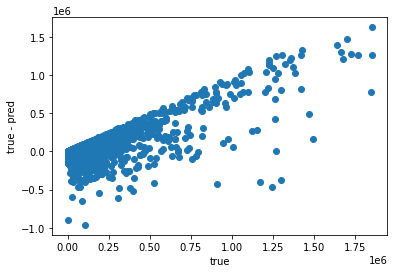

In [28]:
plt.scatter(test_y_true.cpu().numpy(), (test_y_true.cpu()- test_y_pred.cpu()).numpy())
plt.xlabel("true")
plt.ylabel("true - pred")
plt.show()

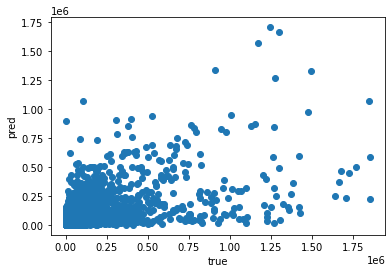

In [29]:
plt.scatter(test_y_true.cpu().numpy(), test_y_pred.cpu().numpy())
plt.xlabel("true")
plt.ylabel("pred")
plt.show()

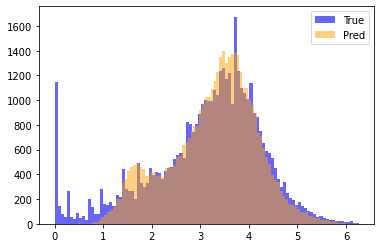

In [30]:
plt.hist(np.log10(test_y_true.cpu().numpy()), bins=100, alpha=0.6, label='True', color='blue')
plt.hist(np.log10(test_y_pred.cpu().numpy()), bins=100, alpha=0.5, label='Pred', color='orange')
plt.legend(loc='upper right')
plt.show()

Correlation between predictions and true values of the response on the test set

In [31]:
np.corrcoef(test_y_true.cpu().numpy(), test_y_pred.cpu().numpy())[0,1]

0.660410906959303

Correlation between residuals and true values of the response on the test set (notice that it's higher than the correlation between predictions and true values)

In [32]:
np.corrcoef(test_y_true.cpu().numpy()-test_y_pred.cpu().numpy(), test_y_true.cpu().numpy())[0,1]

0.7624101521515038